# Office move from Battery Park City, Manhattan to Chicago

Import libraries

In [55]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library
from bs4 import BeautifulSoup

## Get Chicago Neighborhood Names and Zip Codes

Get a URL with all the Chicago zip codes.

In [56]:
url = "https://www.dreamtown.com/maps/chicago-zipcode-map"
page = requests.get(url)
page

<Response [200]>

Turn the html into a soup using Beautiful Soup

In [57]:
soup = BeautifulSoup(page.content, 'html.parser')

The page doesn't display all the data in one table so the number of tables needs to be discovered.

In [58]:
tables = soup.find_all('table')
len(tables)

23

Loop through all the tables scraping the Neighborhood and Zip Code.

In [59]:
chicago_zip = pd.DataFrame(columns=["Neighborhood", "Zip Code"])
R = range(0,23)
for r in R:
    for row in tables[r].tbody.find_all("tr"):
        col = row.find_all("td")
        if (col != []):
            neighborhood = col[0].text
            zipcode = col[1].text
            chicago_zip = chicago_zip.append({"Neighborhood":neighborhood, "Zip Code":zipcode}, ignore_index=True)

chicago_zip.head(10)

,Neighborhood,Zip Code
0,Albany Park,60625
1,Altgeld Gardens,60827
2,Andersonville,60640
3,Arcadia Terrace,60659
4,Archer Heights,60632
5,Ashburn,"60652, 60629"
6,Austin,"60644, 60639, 60651, 60707"
7,Avalon Park,60619
8,Avondale,60618
9,Albany Park,60625


Some neighborhoods have multiple zip codes, because we want to analyse zip codes these need to be split into indivdual rows.

In [60]:
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

# calculate lengths of splits
lens = chicago_zip['Zip Code'].str.split(',').map(len)

# create new dataframe, repeating or chaining as appropriate
chicago_zip = pd.DataFrame({'Neighborhood': np.repeat(chicago_zip['Neighborhood'], lens),
                    'Zip Code': chainer(chicago_zip['Zip Code'])})

chicago_zip['Zip Code'] = chicago_zip['Zip Code'].str.replace(' ', '')

chicago_zip.head(10)

,Neighborhood,Zip Code
0,Albany Park,60625
1,Altgeld Gardens,60827
2,Andersonville,60640
3,Arcadia Terrace,60659
4,Archer Heights,60632
5,Ashburn,60652
5,Ashburn,60629
6,Austin,60644
6,Austin,60639
6,Austin,60651


Save this file to local drive in case a back-up is needed.

In [61]:
#chicago_zip.to_csv('chicago_zip.csv', index=False)

Read the file from local drive if needed.

In [62]:
#chicago_zip = pd.read_csv('chicago_zip.csv')

## Get Coordinates for Zip Codes
Downloaded from https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/?location=2,43.25174,-120.68572&basemap=jawg.streets
This dataset contains every zip code in the USA.

In [64]:
col_list = ['Zip', 'Latitude', 'Longitude']
usa_latlong = pd.read_csv('us-zip-code-latitude-and-longitude.csv', sep=';', usecols=col_list)
usa_latlong.rename(columns = {'Zip' : 'Zip Code'}, inplace = True)
usa_latlong.head(10)

,Zip Code,Latitude,Longitude
0,48834,43.141649,-85.049480
1,55304,45.254715,-93.286520
2,55422,45.014764,-93.339650
3,29079,34.296064,-80.113190
4,29390,34.888237,-81.969020
5,29446,32.683083,-80.560740
6,30018,33.717989,-83.801451
7,30093,33.909952,-84.179400
8,30417,32.162077,-81.909840
9,30627,33.994139,-82.978190


Merge our Chicago zip code data with coordinates from data set above.

In [65]:
chicago_merged = chicago_zip.merge(usa_latlong, how='inner')
chicago_merged.to_csv('chicago_merged.csv', index=False)
chicago_merged.head(10)

,Neighborhood,Zip Code,Latitude,Longitude
0,Albany Park,60625,41.971614,-87.70256
1,Albany Park,60625,41.971614,-87.70256
2,Bowmanville,60625,41.971614,-87.70256
3,Budlong Woods,60625,41.971614,-87.70256
4,Lincoln Square,60625,41.971614,-87.70256
5,North Park,60625,41.971614,-87.70256
6,Ravenswood,60625,41.971614,-87.70256
7,Ravenswood Gardens,60625,41.971614,-87.70256
8,Ravenswood Manor,60625,41.971614,-87.70256
9,Rosehill Cemetery,60625,41.971614,-87.70256


Because we don't have the coordiantes for each neighborhood we can drop this column from the dataframe.
Group all the duplicate zip codes, group by max but all the coordinate data for duplicates are the same so could group by multiple options and get the same result.

In [66]:
chicago_zip_groups = chicago_merged.groupby(['Zip Code'], as_index=False).max()
chicago_zip_groups = chicago_zip_groups.drop(['Neighborhood'], axis=1)
chicago_zip_groups.head(10)

,Zip Code,Latitude,Longitude
0,60601,41.886456,-87.62325
1,60602,41.882937,-87.62874
2,60603,41.880446,-87.63014
3,60604,41.877589,-87.62818
4,60605,41.860019,-87.61870
5,60606,41.882582,-87.63760
6,60607,41.875882,-87.65114
7,60608,41.850532,-87.66990
8,60609,41.814283,-87.65282
9,60610,41.898582,-87.63710


Use Geolocator to get the coordinates of Chicago.

In [67]:
address = 'Chicago, Il'

geolocator = Nominatim(user_agent="chi_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


Create a map of Chicago using latitude and longitude values then add zip code markers.

In [68]:
# create map of Chicago using latitude and longitude values
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, zipcode in zip(chicago_zip_groups['Latitude'], chicago_zip_groups['Longitude'], chicago_zip_groups['Zip Code']):
    label = '{}'.format(zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

## Define FourSquare credentials and Version

In [69]:
CLIENT_ID = 'ONHAR5YDT1R0Z2JTF1P4PJQKLDR41F0OP3WQTQT3H3SMROAD' # your Foursquare ID
CLIENT_SECRET = 'Y1YB5MDP3EYCKDKIYKL1SE3XK0F0SWSSUFC14FON1PUJCPLD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ONHAR5YDT1R0Z2JTF1P4PJQKLDR41F0OP3WQTQT3H3SMROAD
CLIENT_SECRET:Y1YB5MDP3EYCKDKIYKL1SE3XK0F0SWSSUFC14FON1PUJCPLD


Create a function that extracts the category of the venue.

In [70]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Create a function to gather all the venues near our zip code locations.

In [71]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip Code', 
                  'Zip Code Latitude', 
                  'Zip Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Call the function above to iterate through every venue in each zip code.

In [72]:
chicago_venues = getNearbyVenues(names=chicago_zip_groups['Zip Code'],
                                   latitudes=chicago_zip_groups['Latitude'],
                                   longitudes=chicago_zip_groups['Longitude']
                                  )

60601
60602
60603
60604
60605
60606
60607
60608
60609
60610
60611
60612
60613
60614
60615
60616
60617
60618
60619
60620
60621
60622
60623
60624
60625
60626
60628
60629
60630
60631
60632
60633
60634
60636
60637
60638
60639
60640
60641
60643
60644
60645
60646
60647
60649
60651
60652
60653
60654
60655
60656
60657
60659
60660
60661
60707
60827


Check the head of the resulting dataframe to see if it looks how we would expect.

In [73]:
chicago_venues.head()

,Zip Code,Zip Code Latitude,Zip Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,60601,41.886456,-87.62325,sweetgreen,41.884964,-87.624728,Salad Place
1,60601,41.886456,-87.62325,Chicago Architecture Center,41.887720,-87.623650,Tour Provider
2,60601,41.886456,-87.62325,Roti Modern Mediterranean,41.886048,-87.624948,Mediterranean Restaurant
3,60601,41.886456,-87.62325,"LondonHouse Chicago, Curio Collection by Hilton",41.887832,-87.625426,Hotel
4,60601,41.886456,-87.62325,Virgin Hotels Chicago,41.886065,-87.625853,Hotel


Save this dataframe to local file in case a backup is needed.

In [74]:
#chicago_venues.to_csv('chicago_venues.csv', index=False)

Read the backup file from local drive.

In [76]:
#chicago_venues = pd.read_csv('chicago_venues.csv')

Count the number of different venues to ensure none have retuned null or very few venues.

In [77]:
chicago_venues.groupby('Zip Code').count()

,Zip Code Latitude,Zip Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Zip Code,,,,,,
60601,100,100,100,100,100,100
60602,100,100,100,100,100,100
60603,100,100,100,100,100,100
60604,100,100,100,100,100,100
60605,100,100,100,100,100,100
60606,100,100,100,100,100,100
60607,100,100,100,100,100,100
60608,100,100,100,100,100,100
60609,84,84,84,84,84,84


Count the number of unique categories.

In [78]:
print('There are {} uniques categories.'.format(len(chicago_venues['Venue Category'].unique())))

There are 328 uniques categories.


Use one hot encoding and dummies to create a column for each category in each zip code.

In [79]:
# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add Zip Code column back to dataframe
chicago_onehot['Zip Code'] = chicago_venues['Zip Code'] 

# move Zip Code column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

chicago_onehot.head()

,Zip Code,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Canal Lock,Candy Store,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Quad,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,New American Restaurant,Newsstand,Night Market,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pawn Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restau

Group rows by zip code and calculate the mean of the frequency of occurrence of each category.

In [80]:
chicago_grouped = chicago_onehot.groupby('Zip Code').mean().reset_index()
chicago_grouped.head()

,Zip Code,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Canal Lock,Candy Store,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Quad,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,New American Restaurant,Newsstand,Night Market,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pawn Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restau

Function to sort top venues in descending order.

In [81]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Calculate the top 10 venue categories for each zip code, this is necessary for analysis later on when the clusters have been calculated.

In [82]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zipcode_venues_sorted = pd.DataFrame(columns=columns)
zipcode_venues_sorted['Zip Code'] = chicago_grouped['Zip Code']

for ind in np.arange(chicago_grouped.shape[0]):
    zipcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

zipcode_venues_sorted.head()

,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,60601,Hotel,New American Restaurant,Bar,Steakhouse,Park,Italian Restaurant,Grocery Store,Café,Salad Place,Theater
1,60602,Hotel,Steakhouse,Park,Theater,Italian Restaurant,Coffee Shop,Bar,Seafood Restaurant,Mediterranean Restaurant,Donut Shop
2,60603,Hotel,Park,New American Restaurant,Theater,Coffee Shop,Bar,Steakhouse,Italian Restaurant,Pizza Place,Donut Shop
3,60604,Hotel,Coffee Shop,Park,Theater,Steakhouse,Grocery Store,Italian Restaurant,Pizza Place,Salad Place,Gastropub
4,60605,Aquarium,Park,Burger Joint,Chinese Restaurant,Pizza Place,Grocery Store,History Museum,Yoga Studio,Planetarium,Beach


Write this file to local drive for back up.

In [83]:
#zipcode_venues_sorted.to_csv('zipcode_venues_sorted.csv', index=False)

Read the back up file if necessary.

In [84]:
#zipcode_venues_sorted = pd.read_csv('zipcode_venues_sorted.csv')

## Get data for Battery Park City
Use neighborhood_venues_sorted.csv from previou work regarding Manhattan but only keep the Battery Park City data.

In [85]:
batterypark_venues_sorted = pd.read_csv('neighborhoods_venues_sorted.csv')
batterypark_venues_sorted = batterypark_venues_sorted[batterypark_venues_sorted['Neighborhood'] == 'Battery Park City']
batterypark_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Hotel,Clothing Store,Memorial Site,Playground,Gym,Boat or Ferry,Plaza,Sandwich Place


Use manhattan_grouped.csv from previous work to get Battery Park City data.

In [86]:
batterypark_grouped = pd.read_csv('manhattan_grouped.csv')
batterypark_grouped = batterypark_grouped[batterypark_grouped['Neighborhood'] == 'Battery Park City']
batterypark_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Peruvian Roast Chicken Joint,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke

Convert the Zip Code column of the Chicago data to a string to match the manhattan data.

In [87]:
chicago_grouped['Zip Code']= chicago_grouped['Zip Code'].astype(str)

Rename Zip Code and Neighborhood columns so they are consistent.

In [88]:
chicago_grouped.rename(columns = {'Zip Code' : 'Location'}, inplace = True)
batterypark_grouped.rename(columns = {'Neighborhood' : 'Location'}, inplace = True)

Append the manhattan data to the chicago data and fill any null values created in the append with 0.

In [89]:
frames = [chicago_grouped, batterypark_grouped]
all_locations_df = pd.concat(frames, ignore_index=True)
all_locations_df.fillna(0, inplace=True)
all_locations_df.tail()

,Location,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Canal Lock,Candy Store,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Quad,Comedy Club,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,New American Restaurant,Newsstand,Night Market,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pawn Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restau

Change the zip xcode data to a string in the sorted venues dataframe - this will be used for analysis later when clusters have been generated.

In [90]:
zipcode_venues_sorted['Zip Code']= zipcode_venues_sorted['Zip Code'].astype(str)

Rename columns of Chicago and Battery Park data so the columns are consistent  - this will be used for analysis later when clusters have been generated.

In [91]:
zipcode_venues_sorted.rename(columns = {'Zip Code' : 'Location'}, inplace = True)
batterypark_venues_sorted.rename(columns = {'Neighborhood' : 'Location'}, inplace = True)

Append the Battery Park data to the Chicago data  - this will be used for analysis later when clusters have been generated.

In [93]:
frames2 = [zipcode_venues_sorted, batterypark_venues_sorted]
all_locations_top = pd.concat(frames2, ignore_index=True)
all_locations_top.fillna(0, inplace=True)
all_locations_top.tail()

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,60660,Coffee Shop,Grocery Store,Bakery,Diner,Ice Cream Shop,Burger Joint,Sushi Restaurant,Café,Brewery,Breakfast Spot
54,60661,Coffee Shop,Hotel,Italian Restaurant,Steakhouse,New American Restaurant,Donut Shop,Pizza Place,Restaurant,Sandwich Place,Burger Joint
55,60707,Fast Food Restaurant,Grocery Store,Mexican Restaurant,Pizza Place,Italian Restaurant,Coffee Shop,Sandwich Place,Discount Store,Park,Pharmacy
56,60827,Discount Store,Pizza Place,Train Station,Cosmetics Shop,Bar,Bus Station,Gas Station,Harbor / Marina,Health & Beauty Service,Coffee Shop
57,Battery Park City,Park,Coffee Shop,Hotel,Clothing Store,Memorial Site,Playground,Gym,Boat or Ferry,Plaza,Sandwich Place


Read data from local back ups and prepare for merging with top venue data - this will be used for analysis later when clusters have been generated.

In [103]:
chicago_merged = pd.read_csv('chicago_merged.csv')
batterypark_data = pd.read_csv('manhattan_data.csv')
batterypark_data = batterypark_data[batterypark_data['Neighborhood'] == 'Battery Park City']

chicago_merged['Zip Code'] = chicago_merged['Zip Code'].astype(str)
chicago_merged = chicago_merged.drop(['Neighborhood'], axis=1)
chicago_merged = chicago_merged.groupby(['Zip Code'], as_index=False).max()
batterypark_data = batterypark_data.drop(['Borough'], axis=1)

In [104]:
chicago_merged.rename(columns = {'Zip Code' : 'Location'}, inplace = True)
batterypark_data.rename(columns = {'Neighborhood' : 'Location'}, inplace = True)

In [105]:
frames3 = [chicago_merged, batterypark_data]
all_locations_latlong = pd.concat(frames3, ignore_index=True)
all_locations_latlong.fillna(0, inplace=True)

In [106]:
all_locations = all_locations_top.merge(all_locations_latlong, how='inner')
all_locations.head()

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,60601,Hotel,New American Restaurant,Bar,Steakhouse,Park,Italian Restaurant,Grocery Store,Café,Salad Place,Theater,41.886456,-87.62325
1,60602,Hotel,Steakhouse,Park,Theater,Italian Restaurant,Coffee Shop,Bar,Seafood Restaurant,Mediterranean Restaurant,Donut Shop,41.882937,-87.62874
2,60603,Hotel,Park,New American Restaurant,Theater,Coffee Shop,Bar,Steakhouse,Italian Restaurant,Pizza Place,Donut Shop,41.880446,-87.63014
3,60604,Hotel,Coffee Shop,Park,Theater,Steakhouse,Grocery Store,Italian Restaurant,Pizza Place,Salad Place,Gastropub,41.877589,-87.62818
4,60605,Aquarium,Park,Burger Joint,Chinese Restaurant,Pizza Place,Grocery Store,History Museum,Yoga Studio,Planetarium,Beach,41.860019,-87.61870


## K Means Clustering

Create new dataframes with the top venue and mena calulated dataframes.

In [107]:
compare_battery_park_to_chicago_data = all_locations_df.iloc[:58]
compare_battery_park_to_chicago = all_locations.iloc[:58]

Plot a line graph to try and calculate the optimum number of clusters.
However it should be noted the optimum number of clusters isn't the aim of this project, the aim is to find similar location in Chicago to Battery Park City.

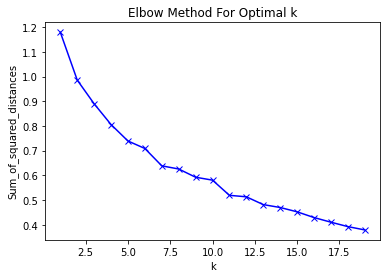

In [108]:
chi_grouped_clustering = compare_battery_park_to_chicago_data.drop('Location', 1)
import matplotlib.pyplot as plt
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(chi_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

I eventually chose to use 12 clusters as this gave enough specificity to cluster a small group with Battery Park City while not being too specific.

In [49]:
# set number of clusters
kclusters = 12

grouped_clustering = compare_battery_park_to_chicago_data.drop('Location', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([ 3,  3,  3,  3,  8,  3,  2,  0,  1,  3,  3,  2,  2,  2,  8,  4,  5,
        2,  5,  5,  5,  2,  0,  7,  4,  8,  7,  0,  4,  4,  1,  9,  4,  7,
        8,  4,  0,  4,  4,  1, 11,  6,  4,  2,  1,  0,  1,  1,  3,  1,  4,
        2,  6,  8,  3,  1, 10,  3])

Display information for Battery Park City including Cluster and 10 most common venues. 
Battery Park City is in Cluster 3.

In [109]:
compare_battery_park_to_chicago.insert(0, 'Cluster', kmeans.labels_)
display(compare_battery_park_to_chicago.iloc[57])

Cluster                                   3
Location                  Battery Park City
1st Most Common Venue                  Park
2nd Most Common Venue           Coffee Shop
3rd Most Common Venue                 Hotel
4th Most Common Venue        Clothing Store
5th Most Common Venue         Memorial Site
6th Most Common Venue            Playground
7th Most Common Venue                   Gym
8th Most Common Venue         Boat or Ferry
9th Most Common Venue                 Plaza
10th Most Common Venue       Sandwich Place
Latitude                          40.711932
Longitude                        -74.016869
Name: 57, dtype: object

Show the location info and most common venues for all of cluster 3.

In [51]:
compare_battery_park_to_chicago.loc[compare_battery_park_to_chicago['Cluster'] == 3]

,Cluster,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,3,60601,Hotel,New American Restaurant,Bar,Steakhouse,Park,Italian Restaurant,Grocery Store,Café,Salad Place,Theater,41.886456,-87.623250
1,3,60602,Hotel,Steakhouse,Park,Theater,Italian Restaurant,Coffee Shop,Bar,Seafood Restaurant,Mediterranean Restaurant,Donut Shop,41.882937,-87.628740
2,3,60603,Hotel,Park,New American Restaurant,Theater,Coffee Shop,Bar,Steakhouse,Italian Restaurant,Pizza Place,Donut Shop,41.880446,-87.630140
3,3,60604,Hotel,Coffee Shop,Park,Theater,Steakhouse,Grocery Store,Italian Restaurant,Pizza Place,Salad Place,Gastropub,41.877589,-87.628180
5,3,60606,Hotel,New American Restaurant,Italian Restaurant,Coffee Shop,Bar,Steakhouse,Donut Shop,Mexican Restaurant,Mediterranean Restaurant,Grocery Store,41.882582,-87.637600
9,3,60610,Steakhouse,Hotel,Pizza Place,New American Restaurant,Italian Restaurant,Restaurant,Mexican Restaurant,Bar,Gym / Fitness Center,Seafood Restaurant,41.898582,-87.637100
10,3,60611,Hotel,American Restaurant,New American Restaurant,Café,Pizza Place,Steakhouse,Restaurant,Grocery Store,Gym / Fitness Center,Coffee Shop,41.904667,-87.625040
48,3,60654,Hotel,Italian Restaurant,Steakhouse,Bar,Mediterranean Restaurant,Coffee Shop,New American Restaurant,Mexican Restaurant,Seafood Restaurant,Burger Joint,41.888627,-87.635380
54,3,60661,Coffee Shop,Hotel,Italian Restaurant,Steakhouse,New American Restaurant,Donut Shop,Pizza Place,Restaurant,Sandwich Place,Burger Joint,41.882082,-87.644610
57,3,Battery Park City,Park,Coffee Shop,Hotel,Clothing Store,Memorial Site,Playground,Gym,Boat or Ferry,Plaza,Sandwich Place,40.711932,-74.016869


Plot a map of Chicago with the different clusters marked in different colors.

In [110]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.Dark2(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, location, cluster in zip(compare_battery_park_to_chicago['Latitude'], compare_battery_park_to_chicago['Longitude'], compare_battery_park_to_chicago['Location'], compare_battery_park_to_chicago['Cluster']):
    label = folium.Popup(str(location) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Plot Cluster 3 in a zoomed in map of Chicago.

In [111]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.Dark2(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, location, cluster in zip(compare_battery_park_to_chicago.loc[compare_battery_park_to_chicago['Cluster'] == 3]['Latitude'], compare_battery_park_to_chicago.loc[compare_battery_park_to_chicago['Cluster'] == 3]['Longitude'], compare_battery_park_to_chicago.loc[compare_battery_park_to_chicago['Cluster'] == 3]['Location'], compare_battery_park_to_chicago.loc[compare_battery_park_to_chicago['Cluster'] == 3]['Cluster']):
    label = folium.Popup(str(location) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters